# BAT.jl Example

The [the tutorial section](https://bat.github.io/BAT.jl/stable/tutorial/) of the BAT.jl documentation should prove helpful.

The cell below installs all the neccessary packages for the example including BAT.

In [1]:
using Pkg
Pkg.add("Distributions")
Pkg.add("IntervalSets")
Pkg.add("ValueShapes")
Pkg.add("Plots")
Pkg.add("ArraysOfArrays")
Pkg.add("StatsBase")
Pkg.add("LinearAlgebra")
Pkg.add("Measurements")
pkg"add https://github.com/bat/BAT.jl#master"

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
   Updating `~/Documents/test/bat-julia-tutorial/Project.toml`
 [no changes]
   Updating `~/Documents/test/bat-julia-tutorial/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Documents/test/bat-julia-tutorial/Project.toml`
 [no changes]
   Updating `~/Documents/test/bat-julia-tutorial/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Documents/test/bat-julia-tutorial/Project.toml`
 [no changes]
   Updating `~/Documents/test/bat-julia-tutorial/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Documents/test/bat-julia-tutorial/Project.toml`
 [no changes]
   Updating `~/Documents/test/bat-julia-tutorial/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Documents/test/bat-julia-tutorial/Project.toml`
 [no changes]
   Updating `~/Documents/test/bat-julia-tutorial/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Documents/test/bat

Pkg.Types.PkgError: `https://github.com/bat/BAT.jl#master` is not a valid package name
The argument appears to be a URL or path, perhaps you meant `Pkg.add(PackageSpec(url="..."))` or `Pkg.add(PackageSpec(path="..."))`.

In [2]:
using BAT
using Distributions 
using IntervalSets
using ValueShapes
using Plots
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Measurements

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260


Plots.PyPlotBackend()

## Situation - Poisson Counting Example
We want to determine the properties of a radioactive singal source in the presence of background from natural sources of radioactivity.
We assume to have one signal source $S$ and only one source of background $B$.

## 1. Background only measurement
+ $k_B=10$ counts with detector without source
+ Determine event rate of natural radioactive background

We define the log-likelihood function, using the function `logpdf()` and type `Poisson` provided by the package [Distributions.jl](https://juliastats.github.io/Distributions.jl/latest/univariate/):

In [3]:
# Number of observed background events
kb = 10

likelihood_B = let k = kb
    params -> begin
        return LogDVal(logpdf(Poisson(params.λb), k)) # poisson log-likelihood
    end
end;

Define the Prior with help of the `NamedTupleDist()` function. Use a flat prior between 0 and 30:

Then use the likelihood and the prior to define the `PosteriorDensity()`:

In [4]:
prior_B = NamedTupleDist(
    λb = 0..30 
);
posterior_B = PosteriorDensity(likelihood_B, prior_B);

Define the settings for the sampling. Choose `MetropolisHastings()` as the algorithm and set the number of chains and samples:

In [5]:
algorithm = MetropolisHastings()
nchains = 8
nsamples = 10^5;

Use the function `bat_sample` to sample the posterior using `nchains` MCMC chains, generating `nsamples` per chain:

In [6]:
samples_B, stats_B = bat_sample(posterior_B, (nsamples, nchains), algorithm)
stats_B

┌ Info: Trying to generate 8 viable MCMC chain(s).
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:161
┌ Info: Selected 8 MCMC chain(s).
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:270
┌ Info: Begin tuning of 8 MCMC chain(s).
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:53
┌ Info: MCMC Tuning cycle 1 finished, 8 chains, 3 tuned, 8 converged.
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:85
┌ Info: MCMC Tuning cycle 2 finished, 8 chains, 3 tuned, 8 converged.
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:85
┌ Info: MCMC Tuning cycle 3 finished, 8 chains, 8 tuned, 8 converged.
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:85
┌ Info: MCMC tuning of 8 chains successful after 3 cycle(s).
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:89


(mode = [10.00000457710987], mean = [10.99817735433726], cov = [10.97346545882748])

Take a look at the resulting disribution for the background rate using `plot()`:

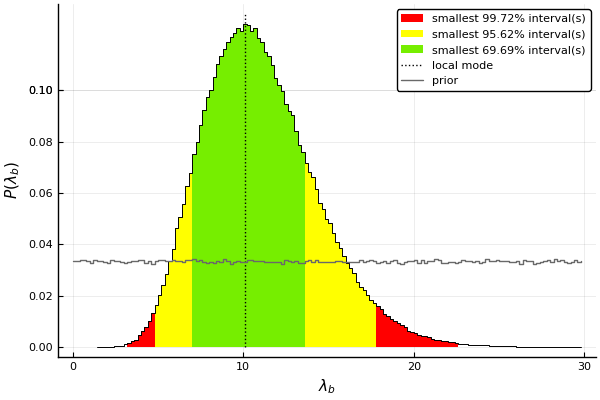

In [7]:
plot(samples_B, :λb)
plot!(prior_B, label="Prior", xlabel = "\$\\lambda_b\$", ylabel = "\$P(\\lambda_b)\$", legend=true)

Print some statistics of the samples:

In [8]:
println("Mode: $(mode(samples_B).λb[1])")
println("Mean: $(mean(samples_B).λb[1])")
println("Covariance: $(var(samples_B).λb[1])")
println("Standard Deviation: $(sqrt(var(samples_B).λb[1]))")

Mode: [10.00000457710987]
Mean: [10.99817735433726]
Covariance: [10.97346545882748]
Standard Deviation: [3.3126221424767843]


## 2. Second background only measurement
+ Second background measurement with $k_B=8$ counts.  
+ Update estimation of background rate 
+ Similar procedure
+ Use the posterior distribution of the previous background measurement as a prior


Define a `StatsBase` histogram containing the previous posterior distribution.

Define it as the prior using `BAT.HistogramAsUvDistribution(histogram)`.  

In [24]:
posterior_hist_B1 = fit(Histogram, BAT.flatview(samples_B.v.λb), FrequencyWeights(BAT.flatview(samples_B.weight)), nbins = 400);

prior_B2 = NamedTupleDist(
    λb = posterior_hist_B1
);

Rest is analogous to the first example.

Define the log-likelihood function and the posterior.

In [10]:
kb2 = 8

likelihood_B2 = let k = kb2
    params -> LogDVal(logpdf(Poisson(params.λb), k))
end;

posterior_B2 = PosteriorDensity(likelihood_B2, prior_B2);

Generate samples.

In [11]:
samples_B2 = bat_sample(posterior_B2, (nsamples, nchains), algorithm).result

┌ Info: Trying to generate 8 viable MCMC chain(s).
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:161
┌ Info: Selected 8 MCMC chain(s).
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:270
┌ Info: Begin tuning of 8 MCMC chain(s).
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:53
┌ Info: MCMC Tuning cycle 1 finished, 8 chains, 8 tuned, 8 converged.
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:85
┌ Info: MCMC tuning of 8 chains successful after 1 cycle(s).
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:89


(mode = [8.80000801704239], mean = [9.496247088151113], cov = [4.771142053663773])

Use the  `plot(samples)` and `plot!(prior)` functions to visualize the posterior of the first analysis and the updated posterior together:

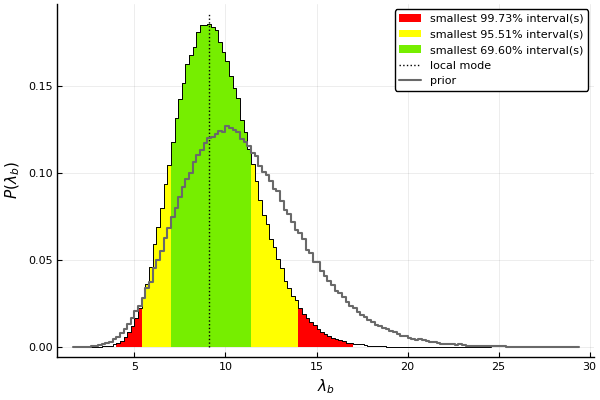

In [12]:
plot(posterior_B2, samples_B2, :λb)
plot!(prior_B2, :λb, linewidth=1.5, xlabel = "\$\\lambda_b\$", ylabel = "\$P(\\lambda_b)\$")

Print some statistics of the samples:

In [13]:
println("Mode: $(mode(samples_B2).λb[1])")
println("Mean: $(mean(samples_B2).λb[1])")
println("Covariance: $(var(samples_B2).λb[1])")
println("Standard Deviation: $(sqrt(var(samples_B2).λb[1]))")

Mode: [8.80000801704239]
Mean: [9.496247088151113]
Covariance: [4.771142053663773]
Standard Deviation: [2.1842944063618743]


## 3. Signal + Background
+ $k_{S+B}=12$ counts using the radioactive source in the setup
+ Determine signal rate $\lambda_s$ using knowledge about background

Define the likelihood for the signal + background model.

In [14]:
# Number of observed events
kSB = 12

likelihood_SB = let k = kSB
    params -> begin
        return LogDVal(logpdf(Poisson(params.λb + params.λs), k))  # poisson log-likelihood for b+s
    end
end;

Define the prior for both the signal and backgound parameters.  
Signal prior is chosen flat while background prior uses the distribution from the earlier measurement.

In [15]:
hist_B2 = fit(Histogram, BAT.flatview(samples_B2.v.λb), FrequencyWeights(BAT.flatview(samples_B2.weight)), nbins = 400)

B2 = hist_B2

prior_SB = NamedTupleDist(
    λb = B2,
    λs = 0..30
)

posterior_SB = PosteriorDensity(likelihood_SB, prior_SB);

Generate samples for the signal + background model:

In [16]:
samples_SB = bat_sample(posterior_SB, (nsamples, nchains), algorithm).result

┌ Info: Trying to generate 8 viable MCMC chain(s).
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:161
┌ Info: Selected 8 MCMC chain(s).
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:270
┌ Info: Begin tuning of 8 MCMC chain(s).
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:53
┌ Info: MCMC Tuning cycle 1 finished, 8 chains, 0 tuned, 8 converged.
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:85
┌ Info: MCMC Tuning cycle 2 finished, 8 chains, 8 tuned, 8 converged.
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:85
┌ Info: MCMC tuning of 8 chains successful after 2 cycle(s).
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/samplers/mcmc/mcmc_tuner.jl:89


(mode = [9.02757979834456, 2.9717880199538484], mean = [9.024280738959439, 4.92840551337454], cov = [3.739610759009937 -2.172223865714376; -2.172223865714376 11.441174016806226])

Plot an overview of the results for both prameters using `plot(samples)`.   

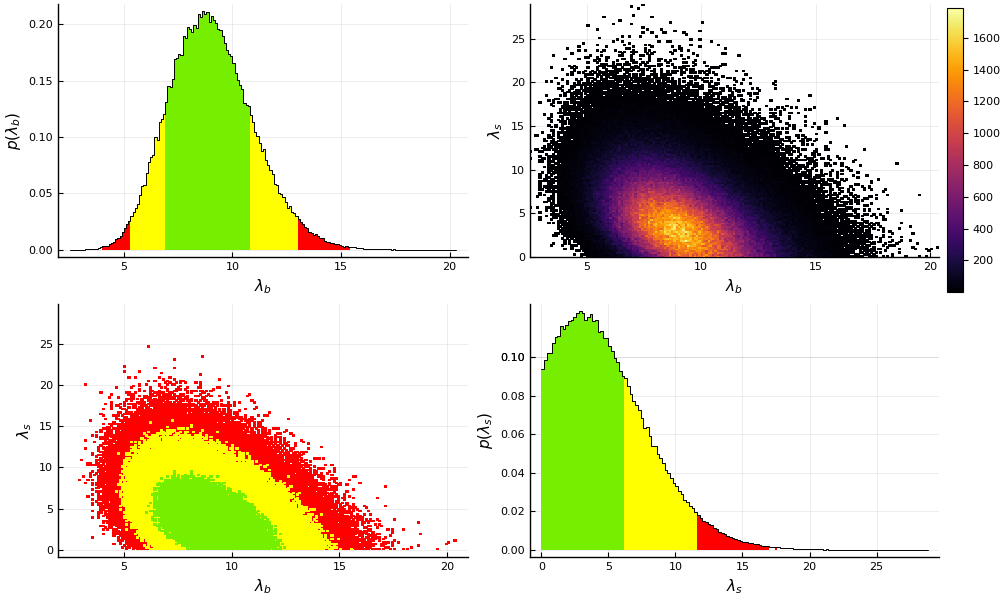

In [17]:
plot(samples_SB, param_labels=["\\lambda_b","\\lambda_s"])

Print some statistics of the samples:

In [18]:
println("Mode: $(mode(samples_SB)[1])")
println("Mean: $(mean(samples_SB)[1])")
println("Variance: $(var(samples_SB)[1])")
println("Standard Deviation: λb = $(sqrt(var(samples_SB).λb[1])), λs = $(sqrt(var(samples_SB).λs[1]))")

Mode: [9.02757979834456, 2.9717880199538484]
Mean: [9.024280738959439, 4.92840551337454]
Covariance: [3.739610759009937 -2.172223865714376; -2.172223865714376 11.441174016806226]
Standard Deviation: [1.888955937692566, 3.3570400343666282]


## 4. Error propagation

+ Calculate cross section using 
### $\frac{\mathrm d N}{\mathrm d t} = \epsilon \cdot σ \cdot L$ 
with the Luminosity $L$ and the efficiency of the detector $\epsilon$. 
+ Can be rewritten to 
### $σ_S = \frac{λ_s}{\epsilon \cdot L}$  .
+ For this axample we assume a luminosity $L = 1.1$  (neglecting units).
+ Result either a measurement or an upper limit on the signal cross section.

+ Assume a known efficiency of $\epsilon = 0.1 \pm 0.02$

Define the luminosity and the efficiency:

In [19]:
L = 1.1
ϵ = rand(Normal(0.1, 0.02), nsamples);

Plot the efficiency.  

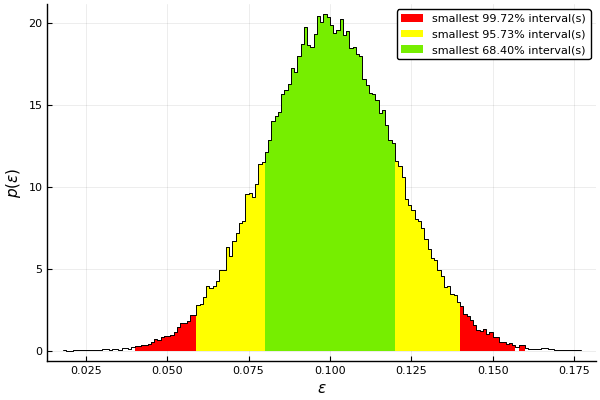

In [20]:
hist_ϵ = fit(Histogram, ϵ, nbins=200)
plot(NamedTupleDist(ϵ=hist_ϵ), 1, seriestype=:smallest_intervals, label="", xlabel="\$\\epsilon\$", ylabel="\$p(\\epsilon)\$")

Get unweighted samples for the signal rate and calculate the cross section distribution:

In [21]:
resampled_SB = bat_sample(samples_SB, nsamples*2).result.v[1:nsamples];
λ_SB = resampled_SB.λs
σS = (λ_SB)./(ϵ*L);

Comparing the error propation using the `Measurements` package to the sample

In [22]:
λ_SB_M = measurement(mean(λ_SB), sqrt(var(λ_SB)))
ϵ_M = measurement(0.1, 0.02)
println(string("Using gaussian error propation: ",λ_SB_M/(ϵ_M*L)))

σS_M = measurement(mean(σS), sqrt(var(σS)))
println(string("Propagating uncertainty with sampling: ",σS_M))

Using gaussian error propation: 45.0 ± 32.0
Propagating uncertainty with sampling: 47.0 ± 35.0


Using sampling we can plot the distribution of the signal cross section.

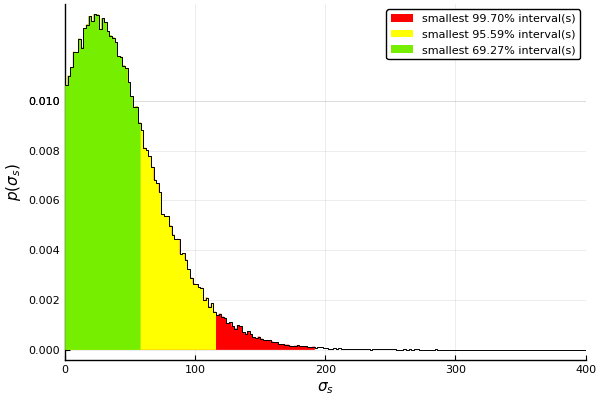

In [23]:
hist_σ = fit(Histogram, σS, nbins=300)
plot(NamedTupleDist(ϵ=hist_ϵ), 1, seriestype=:smallest_intervals, label="", xlabel="\$\\epsilon\$", ylabel="\$p(\\epsilon)\$")

## Integration
A useful feature of `BAT.jl` is to integrate distributions using the samples.
The integration is performed using an Adaptive Harmonic Mean Integration algorithm (AHMI) which is included in BAT.
This is especially useful in the context of hypothesis testing to calculate the [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor). 

In [36]:
bat_integrate(samples_SB,AHMIntegration()).result

┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	400000 / 400000	Parameters:	2
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/integration/ahmi/harmonic_mean_integration.jl:117
┌ Info: Create Space Partitioning Tree
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/integration/ahmi/harmonic_mean_integration.jl:129
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/integration/ahmi/harmonic_mean_integration.jl:145
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/salv/.julia/packages/BAT/aa8AI/src/integration/ahmi/hyper_rectangle.jl:104
┌ Warning: Returned m

(integral = 0.026457 ± 5.9e-5, info = Dict{String,BAT.HMIResult}("cov. weighted result" => BAT.HMIResult{Float64}(0.0264848  +-  7.3885e-5, 0.0264063  +-  9.88728e-5, 0.0264567  +-  5.91854e-5, Dict{String,Any}("Σ" => [3.991427018019188e-8 8.567977354708915e-10 … 6.097223447686673e-9 1.2402479593394491e-8; 8.567977354708915e-10 1.8840002528123838e-8 … 1.629129687621789e-9 2.4976702037376125e-9; … ; 6.097223447686673e-9 1.629129687621789e-9 … 4.9284868261605175e-9 5.473352292538524e-9; 1.2402479593394491e-8 2.4976702037376125e-9 … 5.473352292538524e-9 2.050595542125142e-8]), Dict{String,Any}("Σ" => [1.4686721072635161e-8 1.2814076638263952e-8 … 1.5227437639750404e-8 9.601427834360803e-9; 1.2814076638263952e-8 1.2905138151827145e-8 … 1.4212965700450903e-8 9.464980163458695e-9; … ; 1.5227437639750404e-8 1.4212965700450903e-8 … 1.7461577595624048e-8 1.0041863387251237e-8; 9.601427834360803e-9 9.464980163458695e-9 … 1.0041863387251237e-8 1.0464042417815499e-8]))))